<a href="https://colab.research.google.com/github/cafalchio/EXvivo/blob/main/EEG_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reading data format Intan .dat

In [14]:
!pip install MNE -q

# LFP load and plot

In [1]:
import glob, os
import mmap
from tqdm.notebook import tqdm

import sys
import pandas as pd
import numpy as np
import mne

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.fftpack import fft

# import zipfile
import struct
from resource import getrusage, RUSAGE_SELF
import gc
gc.enable()
# load data
sys.path.append("/content/drive/MyDrive/aHuman_data_Mark/load_intan_rhd_format/")
from load_intan_rhd_format import read_data, read_header
from scipy import signal

## **Read metadata from recording**

Need the channel distribuition of the probe!!


Todo:
<ul>
    <li>Open channels by name or group</li>
    <li>Create MNE objects for EEG</li>
    <li>Bandpass </li

</ul>

Auxiliary functions

From Matlab file analysis

    pxx(1,:) = bandpower(px, f, [1,4], 'psd'); % delta
    pxx(2,:) = bandpower(px, f, [1,4], 'psd'); % duplication of delta - for     creating surf plots
    pxx(3,:) = bandpower(px, f, [4,8], 'psd'); % theta
    pxx(4,:) = bandpower(px, f, [8,13], 'psd'); % alpha
    pxx(5,:) = bandpower(px, f, [13, 30], 'psd'); % beta
    pxx(6,:) = bandpower(px, f, [20, 80], 'psd'); % low gamma

In [70]:
# def butter_filter(data, sample_frequency = 25000., freqs=300, filttype = 'highpass', plot_response = False):
#     """
#     Filter using bidirectional zero-phase shift Butterworth filter.
#     Parameters
#     ----------
#     data : ndarray
#         Data or signal to filter
#     sample_frequency : Sampling frequency

#     wp :
#         Arguments with filter paramters
#     Returns
#     -------
#     ndarray
#         Filtered signal
#     """
#     gstop = 20  # minimum dB attenuation at stopabnd
#     gpass = 3  # maximum dB loss during ripple
#     nyquist = sample_frequency / 2
    
#     if filttype == 'lowpass':
#         wp = freqs / nyquist
#         ws = min([wp + 0.1, 1])
#     elif filttype == 'highpass':
#         wp = freqs / nyquist
#         ws = max([wp - 0.1, 0.01 / nyquist])
#     elif filttype == 'bandpass':
#         wp = [freq / nyquist for freq in freqs] 
#         ws = np.zeros_like(wp)
#         ws[0] = max([wp[0] - 0.1, 0.01 / nyquist])
#         ws[1] = min([wp[1] + 0.1, 1])
#     min_order, min_wp = signal.buttord(wp, ws, gpass, gstop)
#     b, a = signal.butter(min_order, min_wp, btype=filttype, output='ba')
#     freq, h = signal.freqz(b, a, fs=sample_frequency)
#     if plot_response:
#         # Plot
#         fig, ax = plt.subplots(2, 1, figsize=(8, 6))
#         ax[0].plot(freq, 20*np.log10(abs(h)), color='blue')
#         ax[0].set_title("Frequency Response")
#         ax[0].set_ylabel("Amplitude (dB)", color='blue')
#         # ax[0].set_xlim([freqs[0], freq[1]*.3])
#         ax[0].set_ylim([-25, 10])
#         ax[0].grid()
#         ax[1].plot(freq, np.unwrap(np.angle(h))*180/np.pi, color='green')
#         ax[1].set_ylabel("Angle (degrees)", color='green')
#         ax[1].set_xlabel("Frequency (Hz)")
#         # ax[1].set_xlim([0, freqs*10])
#         ax[1].set_yticks([-90, -60, -30, 0, 30, 60, 90])
#         ax[1].set_ylim([-90, 90])
#         ax[1].grid()
#         plt.show()
#         print(f"\nwp: {wp} \nws: {ws}\norder: {min_order}")

#     return signal.filtfilt(b, a, data)

In [3]:
def input_treatment_times(df, slice):
    '''read_times for normal, modified and prepanel

    Input: 
        (df):dataframe with times and treatment
        (str):string of slice name
    Returns:
        list of treatment times
        list of treatment names 
    '''
    t_times = df.loc[df.slice == slice]
    t_dict = t_times.to_dict('records')[0]
    animal = t_dict['animal']
    slices = t_dict['chunks']
    modified = [int(i) for i in t_dict['modified'].split()]
    normal = [int(i) for i in t_dict['normal'].split()]
    perapanel = [int(i) for i in t_dict['perapanel'].split()]
    t_normal = ['normal'] * len(normal)
    t_modified = ['modified'] * len(modified)
    t_perapanel = ['perapanel'] * len(perapanel)
    times = normal + modified + perapanel
    names = t_normal + t_modified + t_perapanel
    times, names = zip(*sorted(zip(times, names)))
    return list(times), list(names)

In [4]:
def calculate_fft(x, window=1):
    '''Calculates the LFP of the signal in windows n minutes'''
    win = window * fs * 60
    g = int(len(x)/win)
    # print(g)
    fftx = []
    for i in range(g):
        start = i*win
        end = i*win+win
        # print(len(data[start:end])/2500)
        fftx.append(fft(x[start:end], n=2048*4))
        break
    return np.array(fftx)

In [71]:
class LFP:
    def __init__(self, path_to_data):
        self.path_to_data = path_to_data
        self.eeg_files = self.find_eeg_files()
        print(f'Found in folder {len(self.eeg_files)} LFP channels')
    
    def find_eeg_files(self, group='A'):
        return sorted(glob.glob(self.path_to_data+'/amp-'+ group +'*.dat'))

    def read_channel(self, channel_idx):
        '''Function that reads a single LFP channel'''
        channel_file = self.eeg_files[channel_idx]        
        data_ch = np.fromfile(channel_file, dtype=np.int16)
        return data_ch

    def plot_raw_sample(self):
        ax = plt.figure(figsize=(20,6))
        ax = plt.plot(1/self.timestamp[2500:5000], self.data[2500:5000])
        ax = plt.ylabel('Voltage uV')
        ax = plt.xlabel('Time (s)')
        plt.show()
        plt.close()

    @staticmethod
    def get_memory_use():
        '''Auxiliary function to check memory use
        '''
        mem = getrusage(RUSAGE_SELF).ru_maxrss/1024000
        print(f'Memory use: {mem:.1f}Gb')
    
    def load_eeg_channels(self, ch_idxs):
        '''
        Read a list of channels and transform from microvolts to volts
        '''
        res = [self.read_channel(ch_idx)/1000000 for ch_idx in tqdm(ch_idxs)] # from microvolts to volts
        return res
    
    def load_mne_channels(self, ch_idxs):
        ''' Load channels by its name ex([0,1]) and 
        transform the EEG to MNE objects, can open 20 
        EEGs per time. It is recommended to open 
        a chunk of 8 files at time
        '''
        print('Reading channels ..')
        data = self.load_eeg_channels(ch_idxs)
        ch_types = len(ch_idxs) * ['eeg']
        names = [f'ch_{idx}' for idx in ch_idxs]
        info = mne.create_info(ch_names=names, sfreq=2500, ch_types=ch_types)
        print('Creating mne EEG type')
        data =  mne.io.RawArray(np.array(data), info, verbose='ERROR')
        print('Applying notch filter')
        data = data.notch_filter(np.arange(50, 251, 50)) # Filter 50Hz
        print('Bandpassing 2 - 100 Hz')
        data = data.filter(l_freq=1, h_freq=100)
        self.get_memory_use()
        print('Done!')
        return data

In [72]:
# !ls '/content/drive/MyDrive/aHuman_data_Mark/HUMAN_214/slice1_151015_130152/downsampleLFP/'

In [59]:
df = pd.read_csv('/content/drive/MyDrive/aHuman_data_Mark/treatment_times.csv')
df.head(10)

,slice,animal,normal,modified,perapanel,uM,chunks
0,slice1_151002_185204,212,0,26,89,3,1
1,slice1_151008_165239,213,0 248,18 178,86,1,1
2,slice1_151015_130152,214,0 204,20 174,82,1,1
3,slice2_151015_165854,214,0 204,10 194,88,1,1
4,slice1_151020_133348,215,0 256,69 196,130,1,1
5,slice2_151020_185053,215,0 224,50 186,110,1,1
6,session1_151106_154501,216,0 315,60 255,121 195,1 3,2
7,human_151124_145847,218,0,20,80,1,2
8,human_151124_172920,218,0,10,70,1,2
9,human_151124_200111,218,0,5,55,1,2


In [60]:
# Load the data folder
lfps = LFP(r'/content/drive/MyDrive/aHuman_data_Mark/HUMAN_214/slice1_151015_130152/downsampleLFP/')
len(lfps.eeg_files)

Found in folder 64 LFP channels


64

In [61]:
slice1_151015_130152 = lfps.load_mne_channels(range(1))

Reading channels ..


  0%|          | 0/1 [00:00<?, ?it/s]

Creating mne EEG type
Applying notch filter
Bandpassing 2 - 100 Hz
Memory use: 6.3Gb
Done!


In [62]:
print(f'Recorded for {(len(slice1_151015_130152.get_data(0)[0])/2500)/60} minutes')

Recorded for 213.18864 minutes


In [63]:
# LFPs.plot(start=1900)

## RAT 213:

### Separate the different treatment times
**Times in minutes:**
    
    0 - normal ACSF
    18 - Modified
    86 - 1uM Perapanel
    178 - modified
    248 - normal




### RAT 214 


**Slice 1**: 

slice1_151015_130152

Times in minutes:

    0 - normal ACSF
    20 - Modified
    82 - 1uM Perapanel
    174 - modified
    204 - normal

**Slice 2**

Times in minutes:

    0 - normal ACSF
    10 - Modified
    88 - 1uM Perapanel
    194 - modified
    204 - normal

## Plot treatments time

In [64]:
df = pd.read_csv('/content/drive/MyDrive/aHuman_data_Mark/treatment_times.csv')
treatment_times = input_treatment_times(df, 'slice1_151015_130152')
treatment_times

([0, 20, 82, 174, 204],
 ['normal', 'modified', 'perapanel', 'modified', 'normal'])

In [65]:
def plot_nice(data, treatments, slice_name = 'slice1_151015_130152'):
    '''Adapted from Raphael Vallat blog
    '''
    colors = {
            'normal':'green',
            'modified':'red',
            'perapanel':'blue'
        }
    fs = 2500
    sns.set(font_scale=1.2)
    # Define sampling frequency and time vector
    time = np.arange(data.size) / fs
    # return time
    # Plot the signal
    fig, ax = plt.subplots(1, 1, figsize=(20, 4))
    plt.plot(time, data, lw=1.5, color='k')
    treatments[0] = [x*fs*60 for x in treatments[0]]
    treatments[0].append(time.size-1)
    for i in range(len(treatment_times[1])):
        plt.axvspan(time[treatments[0][i]], time[treatments[0][i+1]], 
                        label=treatments[1][i], color=colors[treatments[1][i]], 
                        alpha=0.1)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Voltage')
    plt.title(slice_name)
    plt.xlim([time.min(), time.max()])
    plt.legend(loc='upper right')
    # plt.savefig(f'{slice_name}_treatments_ch0_no_notch.jpg')
    sns.despine()

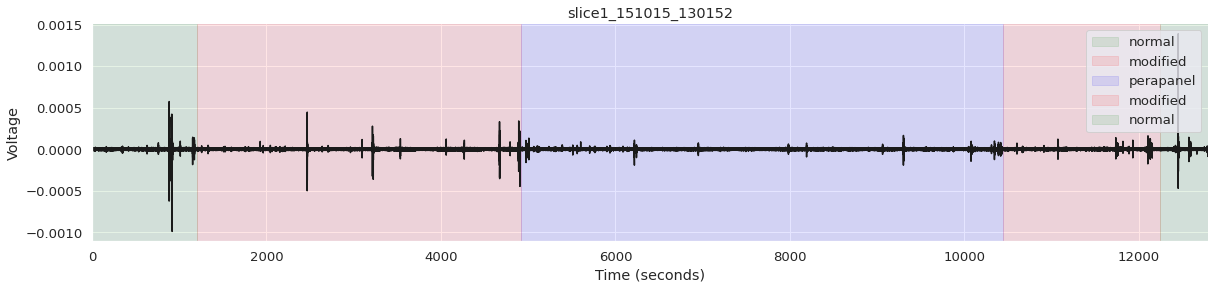

In [66]:
# data = LFPs.get_data()
fs = 2500
for d in slice1_151015_130152.get_data():
    plot_nice(d, list(treatment_times))

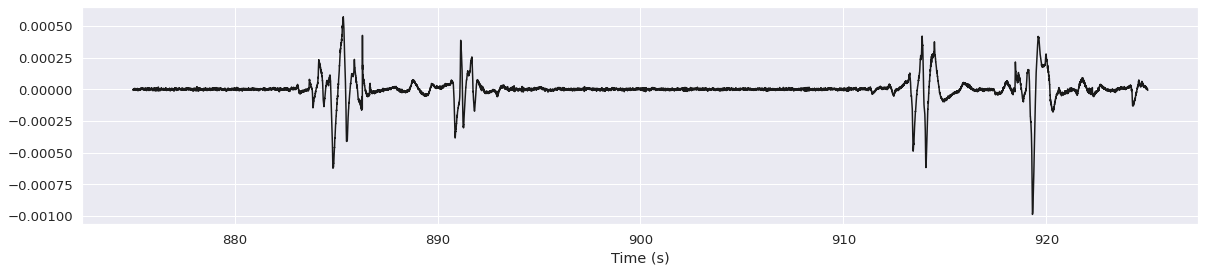

In [67]:
zoom = [875,925]

data = slice1_151015_130152.get_data()[0]
# block = 0
# t1 = treatment_times[0][block]*60*fs
# t2 = treatment_times[0][block+1]*60*fs
# data = data[t1:t2]
data = data[zoom[0]*fs:zoom[1]*fs]
time = np.arange(data.size) / fs
time  = time + zoom[0]
# Plot the signal
fig, ax = plt.subplots(1, 1, figsize=(20, 4))
plt.plot(time, data, lw=1.5, color='k')
# plt.title(f'{treatment_times[1][block]}')
plt.xlabel('Time (s)')
plt.show()

## Calculate gama power in different treatments

    Use windows (1-10) min
    

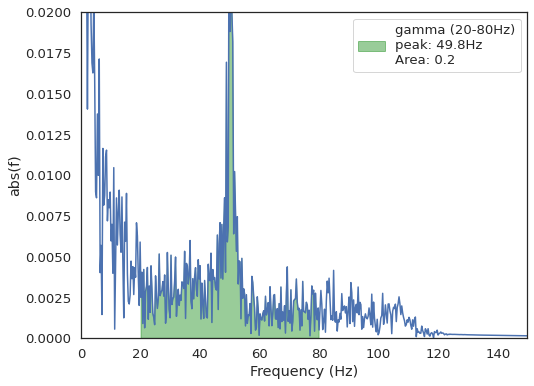

In [73]:
# Calculate FFT for the signal in windows of 1 minute
ffts = calculate_fft(slice1_151015_130152.get_data()[0], window=1)
ffts.mean(axis=0)
sns.set(font_scale=1.2, style='white')
max_freq = 1250
freqs = np.linspace(0, 1, 4096) * 1250
idx_delta = np.logical_and(freqs >= 20, freqs <= 80)
plt.figure(figsize=(8,6))
res_fft = 2*np.abs(ffts.mean(axis=0)[:4096])
plt.plot(freqs,res_fft)
plt.xlim(0,150)
plt.ylim(0,0.02)
idx = (freqs >=20.) & (freqs<=80)
x = freqs[idx]
y = res_fft[idx]
plt.fill_between(freqs, res_fft, where=idx_delta, color='green', alpha=.4, label = 
                 f'gamma (20-80Hz)\npeak: {x[np.where(y == y.max())][0]:.1f}Hz\nArea: {np.trapz(x=x, y=y):.1f}')
plt.xlabel('Frequency (Hz)')
plt.ylabel('abs(f)')
plt.legend()
# plt.title('power using notch')
# plt.savefig('slice1_151015_130152_power_with_notch.jpg')
plt.show()


# print(f'Area under the curve in gamma: {np.trapz(x=x, y = y):.2f},  max frequency {x[np.where(y == y.max())][0]:.2f}Hz')